# ShallowWater Results
Notebook for testing the U-Net with the datasets used for training: 'Box_Single_Drop'.

In [1]:
import numpy as np
import torch
from torch import optim, nn
from torchvision import transforms
import deepfluids as df   # <----------- This is our module 
import warnings
warnings.filterwarnings("ignore")

In [2]:
core = 0
device = torch.device("cuda:"+str(core) if torch.cuda.is_available() else "cpu")
print("Using",device)

Using cuda:0


Select the hyper-parameters:

In [3]:
unet_hyperparams = df.learning.ConvNetHyperparams.from_dict({
    "kernel_size": 3,
    "stride": 1,
    "padding": 1,
    "pooling": 0,
    "input_size": (128, 128),
    "filters_dimensions": [64, 128, 256],
})

hyperparams = df.learning.Hyperparams.from_dict({
    "n_frames_in": 5,
    "n_frames_out": 5,
    "n_frames_skip": 3,
})

Load the pre-trained model

In [4]:
model = df.models.UNet(hyperparams, unet_hyperparams, omega=True).to(device)
model.load_state_dict(torch.load("trainedSwUNet.pt", map_location=device))

<All keys matched successfully>

## Testing
### Box_Single_Drop

In [5]:
root = "/home/mal1218/datasets/ShallowWater"
dataset = df.datasets.ShallowWater(root, hyperparams, keys=["Box_Single_Drop"])
dataset.transform = transforms.Compose([
    df.transforms.filter.Solid2Value(1),
    df.transforms.resize.Resize((128, 128)),
    df.transforms.rotate.RandomRotate(90),
    df.transforms.rotate.RandomRotate(180),
    df.transforms.rotate.RandomRotate(270),
    df.transforms.flip.RandomHFlip(),
    df.transforms.flip.RandomVFlip(),
    df.transforms.convert.ToTensor(),
    df.transforms.normalise.Scale(1,1.1)
    ])

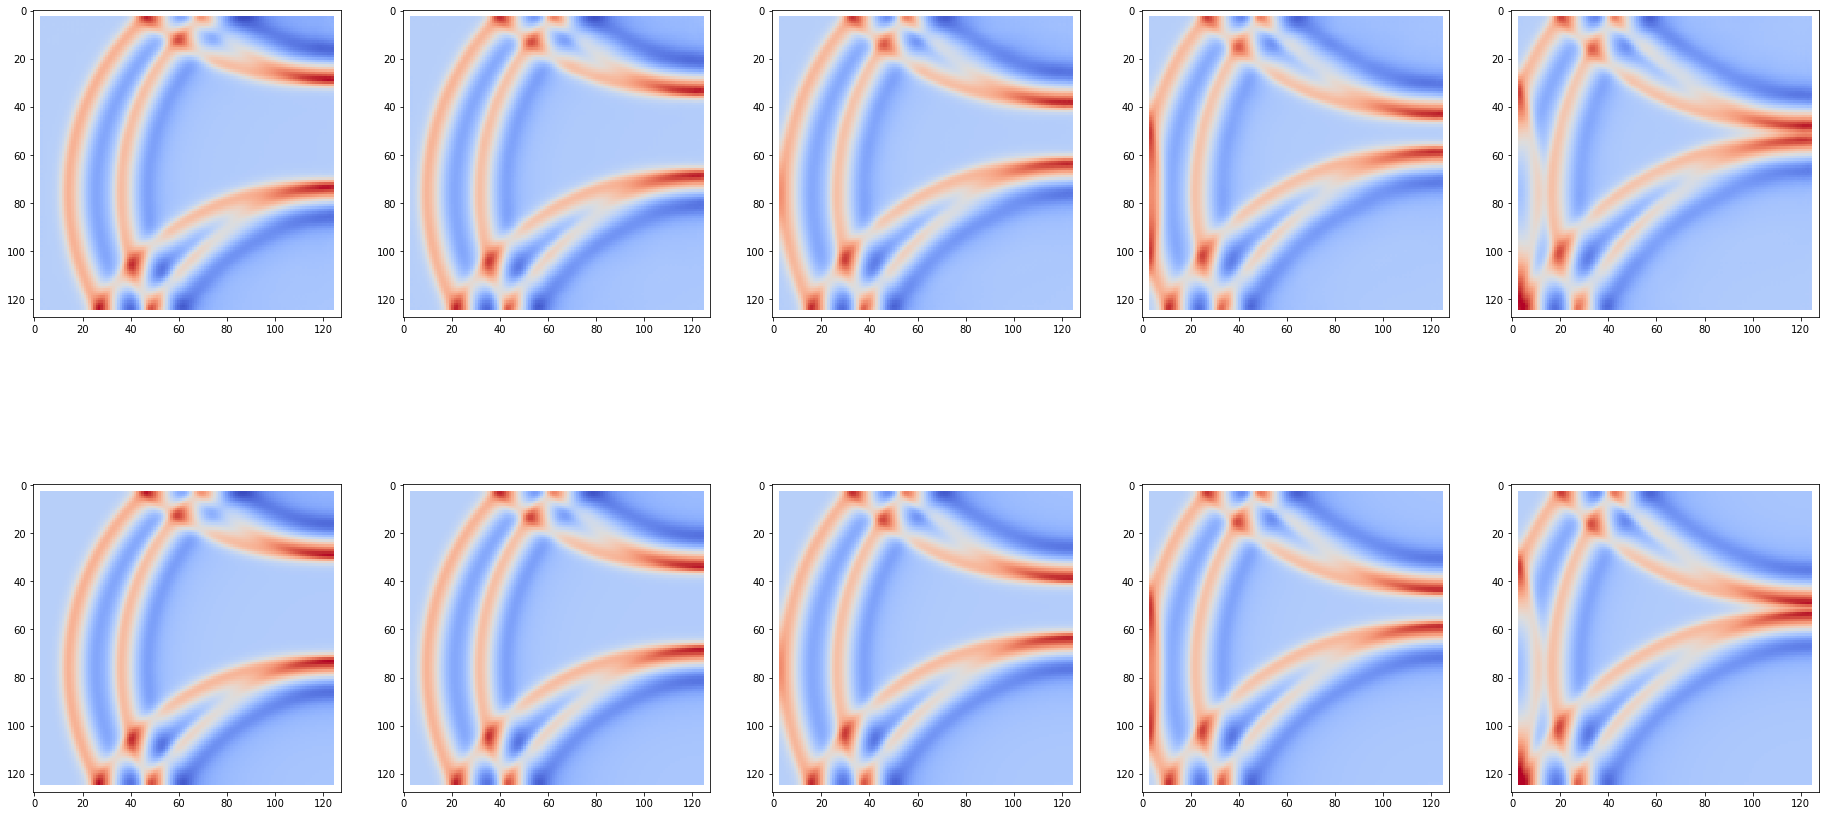

In [6]:
sample = dataset.get_sequence(1,60) # (sequence number, time step within the sequence)
input_frames = torch.stack([sample["Omega"],*sample["Input"]], dim=1).to(device)
pred = model.infer(input_frames, 5) # prediction
vmin, vmax = torch.min(sample["Output"][0]).item(), torch.max(sample["Output"][0]).item()
df.visualize.plot.plot_field(pred, sample["Output"], sample["Omega"], vmin, vmax) # fisrt row: pred, second row: target